In [130]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta

In [131]:
df = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df.head()

,start_time,end_time,total_time_hours
date,,,
2021-02-23,2021-02-23 13:00:00,2021-02-23 16:00:00,3.0
2021-03-29,2021-03-29 10:00:00,2021-03-29 13:00:00,3.0
2021-04-22,2021-04-22 08:30:00,2021-04-22 11:30:00,3.0
2021-04-29,2021-04-29 11:30:00,2021-04-29 14:30:00,3.0
2021-05-15,2021-05-15 17:30:00,2021-05-15 19:00:00,1.5


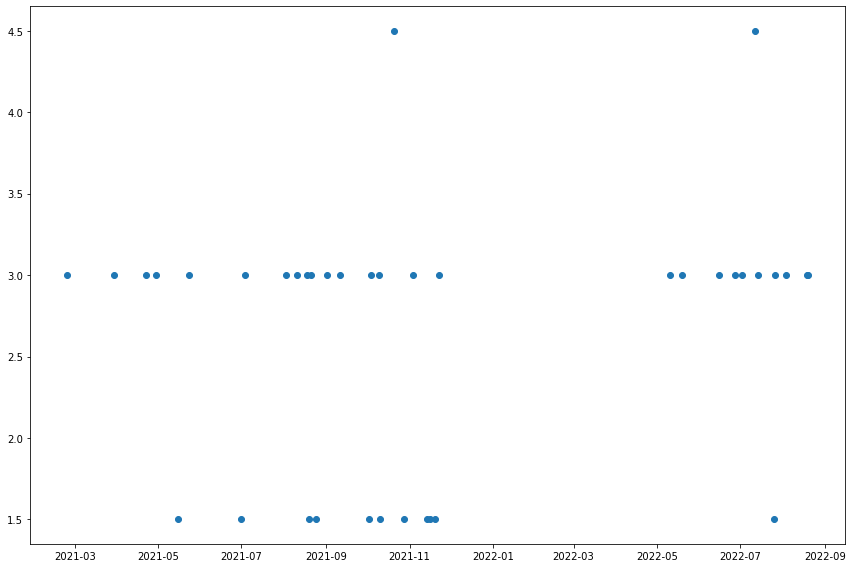

In [132]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.start_time, df.total_time_hours)
plt.tight_layout()
plt.show()

In [133]:
df = df.drop(['start_time', 'end_time'], axis=1)
df.head()

,total_time_hours
date,
2021-02-23,3.0
2021-03-29,3.0
2021-04-22,3.0
2021-04-29,3.0
2021-05-15,1.5


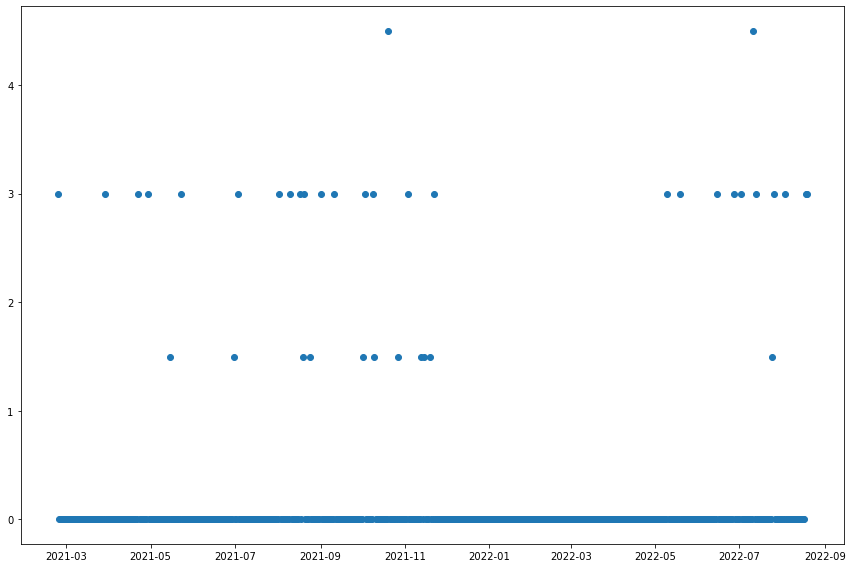

In [6]:
df = df.resample('D').mean().replace(np.nan, 0)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.index, df)
plt.tight_layout()
plt.show()

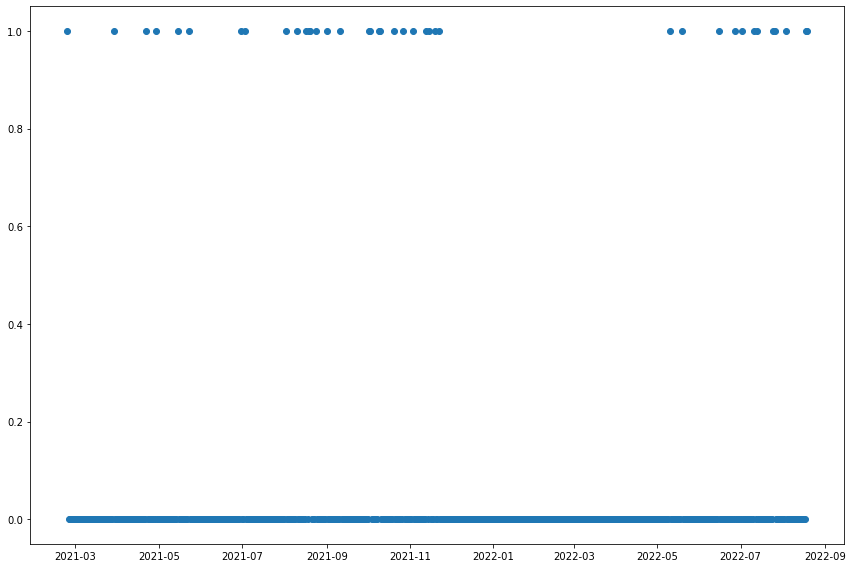

In [7]:
df_binary = df.copy()
df_binary[df_binary > 0] = 1
df_binary.rename(columns={'total_time_hours': 'booked'}, inplace=True)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df_binary.index, df_binary)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

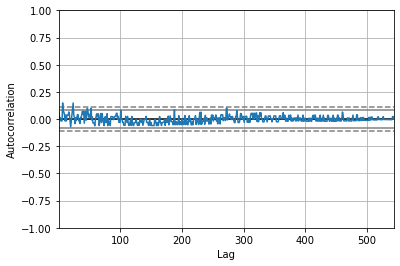

In [8]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_binary['booked'])

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_binary.booked.to_numpy(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  543
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -74.844
Date:                Tue, 30 Aug 2022   AIC                            161.688
Time:                        20:17:56   BIC                            187.459
Sample:                             0   HQIC                           171.765
                                - 543                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7655      0.032    -24.083      0.000      -0.828      -0.703
ar.L2         -0.5965      0.042    -14.043      0.000      -0.680      -0.513
ar.L3         -0.4299      0.047     -9.116      0.0

In [10]:
forecast = model_fit.forecast(steps=31)
forecast

array([0.40349746, 0.43017565, 0.47127892, 0.52879272, 0.62432348,
       0.58177584, 0.51649405, 0.52761836, 0.53950544, 0.54987945,
       0.55572547, 0.54657237, 0.54044729, 0.54322773, 0.54539544,
       0.54651855, 0.54636022, 0.54498961, 0.54459101, 0.5451227 ,
       0.54541911, 0.54547378, 0.54535157, 0.54518902, 0.54519503,
       0.54527892, 0.54530868, 0.54529964, 0.54527561, 0.545261  ,
       0.54526893])

In [11]:
df_binary.iloc[-1]

booked    1.0
Name: 2022-08-19 00:00:00, dtype: float64

In [12]:
dates_forward = [{'date': datetime.today() + timedelta(days=i), 'booked': forecast[i-1]} for i in range(1, len(forecast))]
print(f"Most likely day to to book laundry slot: {dates_forward[np.argmax(forecast)]['date'].date()} ")

Most likely day to to book laundry slot: 2022-09-04 


In [13]:
preds = pd.DataFrame.from_dict(dates_forward).set_index('date')

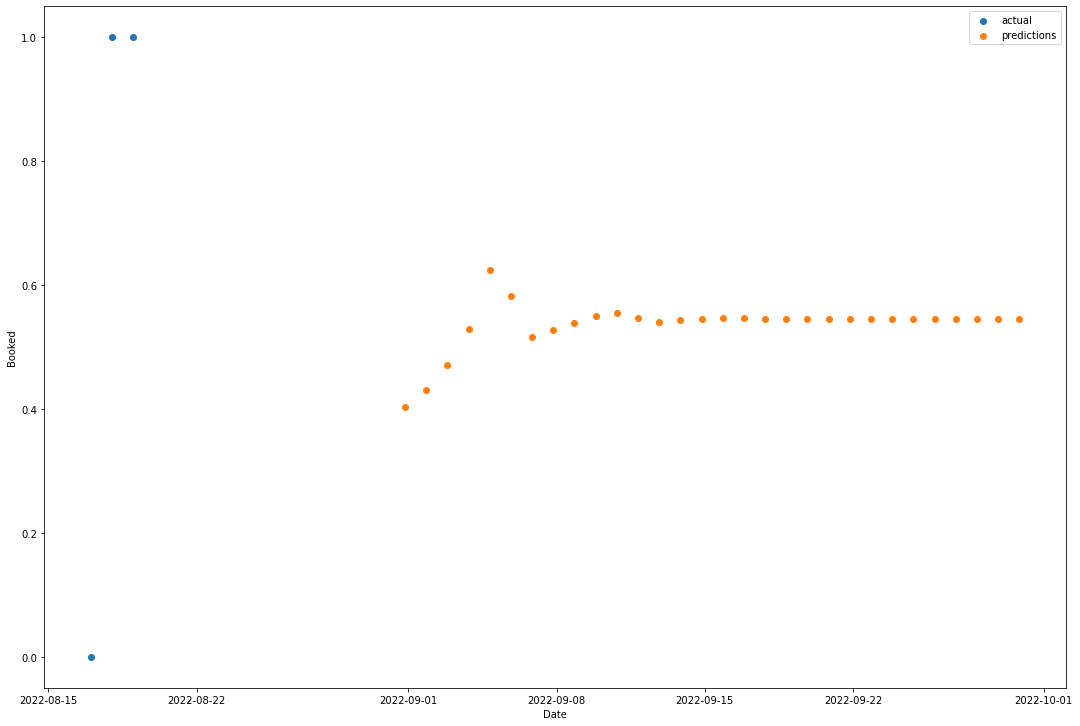

In [14]:
from datetime import date


fig = plt.figure(figsize=(15, 10))

smaller_window = df_binary.index > datetime.today() - timedelta(days=14)

plt.scatter(df_binary[smaller_window].index, df_binary[smaller_window], label='actual')
plt.scatter(preds.index, preds, label='predictions')
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Booked')
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression

In [153]:
df_rolling = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df_rolling = df_rolling.drop(['start_time', 'end_time'], axis=1)
df_rolling[df_rolling > 0] = 1
df_rolling.head()

,total_time_hours
date,
2021-02-23,1.0
2021-03-29,1.0
2021-04-22,1.0
2021-04-29,1.0
2021-05-15,1.0


In [210]:
df_rolling = df_rolling.reset_index()
df_rolling['days_since_booked'] = (df_rolling.date - np.roll(df_rolling.date, shift=1))
df_rolling.days_since_booked = df_rolling.days_since_booked.apply(lambda x: x.days)
# Change values of first row to 0
df_rolling.days_since_booked.iloc[0] = 0
df_rolling.rename(columns={'total_time_hours': 'booked'}, inplace=True)
# drop first row
df_rolling = df_rolling.drop(df_rolling.index[0])
df_rolling.head()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,date,booked,days_since_booked
1,1,2021-03-29,1.0,34
2,2,2021-04-22,1.0,24
3,3,2021-04-29,1.0,7
4,4,2021-05-15,1.0,16
5,5,2021-05-23,1.0,8


In [211]:
df_rolling_filled_dates = df_rolling.set_index('date').resample('D').mean()
# increment by 1 each day until the next booking    
for idx, row in df_rolling_filled_dates.iterrows():
    if row.booked == 1:
        counter = 1
    else:
        row.days_since_booked = counter
        counter += 1
df_rolling_filled_dates.replace(np.nan, 0, inplace=True)
df_rolling_filled_dates.head(0)

,index,booked,days_since_booked
date,,,


In [249]:
lr = LogisticRegression()
X, y = df_rolling_filled_dates.days_since_booked.values.reshape(-1, 1), df_rolling_filled_dates.booked.values.ravel()
# split 
from sklearn.model_selection import train_test_split
N = len(X)
print(N)
X_train, X_test, y_train, y_test = X[:int(N*0.8)], X[int(N*0.8):], y[:int(N*0.8)], y[int(N*0.8):]
print('Length of training set: ', len(X_train))
print('Length of test set: ', len(X_test))
lr.fit(X_train, y_train)


509
Length of training set:  407
Length of test set:  102


LogisticRegression()

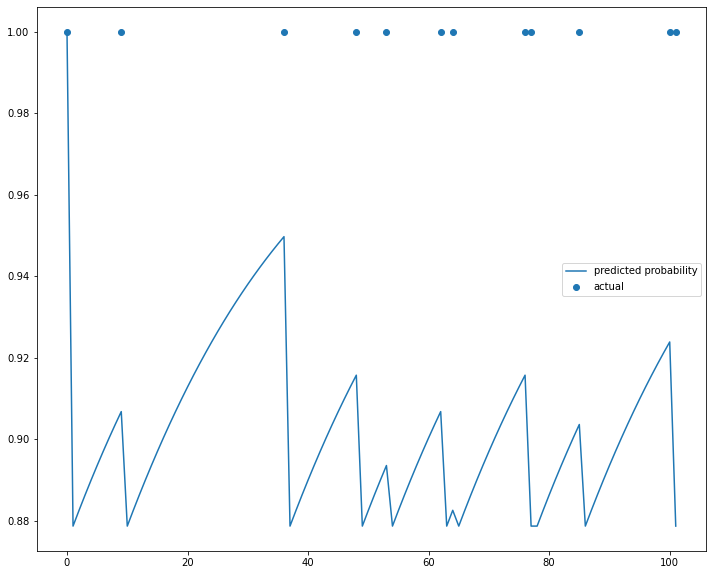

In [253]:
vals = np.arange(0, X_test.shape[0])
plt.figure(figsize=(12, 10))
plt.plot(vals, lr.predict_proba(X_test)[:, 0], label='predicted probability')
plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.show()


<AxesSubplot:xlabel='date'>

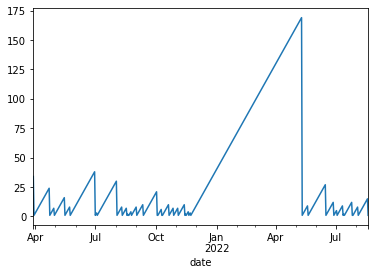

In [214]:
df_rolling_filled_dates.days_since_booked.plot()

In [215]:
df_rolling_filled_dates[df_rolling_filled_dates.booked == 1]

,index,booked,days_since_booked
date,,,
2021-03-29,1.0,1.0,34.0
2021-04-22,2.0,1.0,24.0
2021-04-29,3.0,1.0,7.0
2021-05-15,4.0,1.0,16.0
2021-05-23,5.0,1.0,8.0
2021-06-30,6.0,1.0,38.0
2021-07-03,7.0,1.0,3.0
2021-08-02,8.0,1.0,30.0
2021-08-10,9.0,1.0,8.0
